## 0. Setup and Imports

In [131]:
import os
import pandas as pd
import numpy as np
import yfinance as yf

## 1. Data Access / Cleaning

In [35]:
TICKER = 'AAPL'
START_DATE = '2000-01-01'
END_DATE = '2024-12-31'
START_TEST = '2025-01-01'
END_TEST = '2025-06-31'
INTERVAL = '1d'
FREQ = 'D'
LAGS = [1, 2, 3, 5]
ROLL_WINDOW = 5

# =====================
# === Доступ до даних ===
# =====================

def download_data(ticker: str, start: str, end: str, interval: str) -> pd.DataFrame:
    df = yf.download(ticker, start=start, end=end, interval=interval, progress=False)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    df.index = pd.to_datetime(df.index)
    return df

# =====================
# === Очищення ===
# =====================

def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Вирівнювання частоти
    df = df.asfreq(FREQ)
    # Інтерполяція
    df = df.interpolate(method='time')
    # Видалення викидів
    num = df.select_dtypes(include=[np.number])
    z = np.abs((num - num.mean()) / num.std())
    df = df[(z < 3.0).all(axis=1)]
    return df

# =====================
# === Індикатори ===
# =====================

def SMA(series: pd.Series, window: int) -> pd.Series:
    return series.rolling(window).mean()

def EMA(series: pd.Series, span: int) -> pd.Series:
    return series.ewm(span=span, adjust=False).mean()

def bollinger(series: pd.Series, window: int, num_std: int):
    m = SMA(series, window)
    s = series.rolling(window).std()
    return m + num_std * s, m - num_std * s

def RSI(series: pd.Series, window: int) -> pd.Series:
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def MACD(series: pd.Series, fast: int, slow: int, signal: int) -> pd.DataFrame:
    """
    Calculate MACD, Signal, and Histogram for given price series
    
    Parameters:
    - series: Price series (typically close prices)
    - fast: Fast EMA period
    - slow: Slow EMA period
    - signal: Signal line period
    
    Returns:
    - DataFrame with MACD, Signal, and Histogram columns
    """
    # Ensure we're working with a pandas Series with the right shape
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    
    # Calculate EMA values
    ma_fast = series.ewm(span=fast, adjust=False).mean()
    ma_slow = series.ewm(span=slow, adjust=False).mean()
    
    # Calculate MACD line
    macd_line = ma_fast - ma_slow
    
    # Calculate signal line
    sig_line = macd_line.ewm(span=signal, adjust=False).mean()
    
    # Calculate histogram (difference between MACD and signal line)
    hist = macd_line - sig_line
    
    # Create an empty DataFrame with the same index as the input series
    result = pd.DataFrame(index=series.index)
    
    # Add each column individually to avoid dimensionality issues
    result['MACD'] = macd_line
    result['Signal'] = sig_line
    result['Hist'] = hist
    
    return result

def ATR(df: pd.DataFrame, window: int) -> pd.Series:
    hl = df['High'] - df['Low']
    hc = (df['High'] - df['Close'].shift()).abs()
    lc = (df['Low'] - df['Close'].shift()).abs()
    tr = pd.concat([hl, hc, lc], axis=1).max(axis=1)
    return tr.rolling(window).mean()

# =====================
# === Створення ознак ===
# =====================

def create_features(df: pd.DataFrame) -> pd.DataFrame:
    feats = pd.DataFrame(index=df.index)
    # Додати базові стовпці OHLCV
    feats[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']]
    # Технічні індикатори
    feats['SMA20'] = SMA(df['Close'], 20)
    feats['EMA20'] = EMA(df['Close'], 20)
    up, low = bollinger(df['Close'], 20, 2)
    feats['BB_up'], feats['BB_low'] = up, low
    feats['RSI'] = RSI(df['Close'], 14)
    # MACD
    # macd_df = MACD(df['Close'], 12, 26, 9)
    # feats = pd.concat([feats, macd_df], axis=1)
    feats['ATR'] = ATR(df, 14)
    # Лаг-ознаки
    for lag in LAGS:
        feats[f'lag_{lag}'] = df['Close'].shift(lag)
    # Ковзні статистики
    ret = df['Close'].pct_change()
    feats['ret_mean'] = ret.rolling(ROLL_WINDOW).mean()
    feats['ret_std'] = ret.rolling(ROLL_WINDOW).std()
    feats = feats.dropna()
    return feats

# =====================
# === Підготовка X та y ===
# =====================

def prepare_xy(df):
    X = create_features(df)
    y = df.loc[X.index, 'Close']
    return X, y

# =====================
# === Головна функція ===
# =====================


raw = download_data(TICKER, START_DATE, END_DATE, INTERVAL)
clean = clean_data(raw)
X, y = prepare_xy(clean)
print(f"Готово: X.shape={X.shape}, y.shape={y.shape}")


Готово: X.shape=(8805, 17), y.shape=(8805, 1)


## 2. Pre-trade Analysis 

           mean       std      skew   kurtosis       min       max
Close  0.000832  0.019058 -3.097349  97.285633 -0.558411  0.166034
       adf_stat  adf_pvalue  kpss_stat  kpss_pvalue
Close   2.32884    0.998973  10.825631         0.01


C:\Users\b.yarinko\AppData\Local\Temp\ipykernel_20036\1438854071.py:37: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_res = kpss(series.dropna(), regression='c')


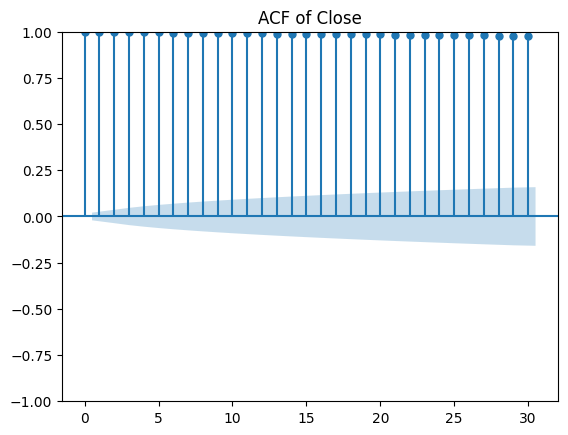

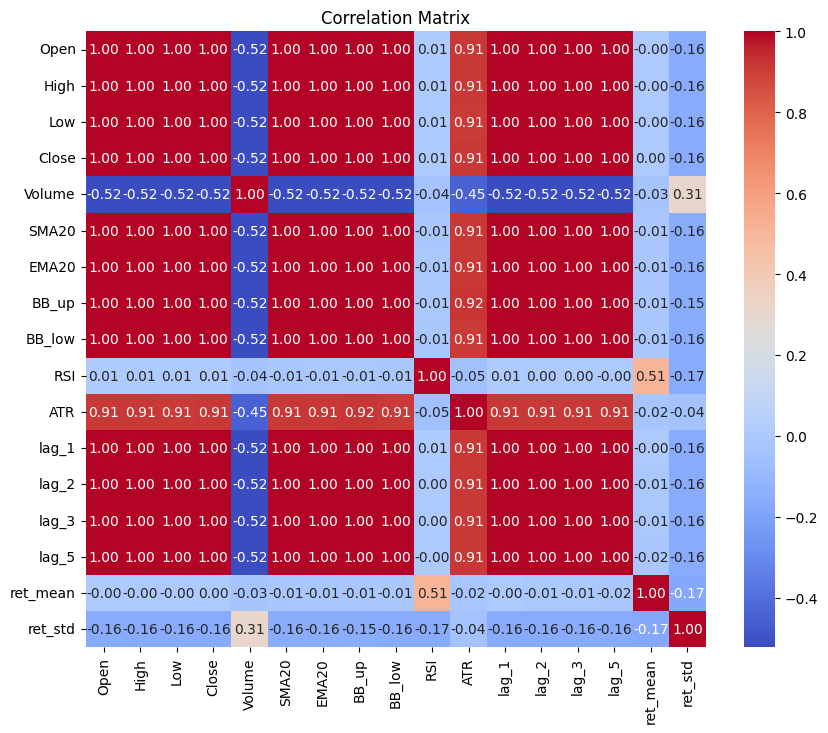

                     PC1         PC2        PC3
Date                                           
2000-01-23  1.020209e+08  -96.745932   6.101285
2000-01-24  8.367154e+07 -102.896773   4.355056
2000-01-25  1.399403e+08  -84.066153  10.573321
2000-01-26  9.953141e+06 -127.577662  14.607344
2000-01-27 -1.706126e+07 -136.661201  24.579844


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from scipy.stats import kurtosis, skew
from sklearn.decomposition import PCA
import seaborn as sns

# =====================
# === Етап 2: Pre-trade Analysis ===
# =====================

# 1. Непараметричні статистики доходностей
# -----------------------------------------
def compute_return_stats(df: pd.DataFrame) -> pd.DataFrame:
    """
    Обчислює базові статистики доходностей для кожного стовпця в df
    """
    ret = df.pct_change().dropna()
    stats = pd.DataFrame(index=ret.columns)
    stats['mean'] = ret.mean()
    stats['std'] = ret.std()
    stats['skew'] = skew(ret)
    stats['kurtosis'] = kurtosis(ret)
    stats['min'] = ret.min()
    stats['max'] = ret.max()
    return stats

# 2. Тести на stationarity
# ------------------------

def stationarity_tests(series: pd.Series) -> dict:
    """
    Виконує ADF та KPSS тести для серії
    """
    adf_res = adfuller(series.dropna(), autolag='AIC')
    kpss_res = kpss(series.dropna(), regression='c')
    return {
        'adf_stat': adf_res[0], 'adf_pvalue': adf_res[1],
        'kpss_stat': kpss_res[0], 'kpss_pvalue': kpss_res[1]
    }

def run_stationarity(df):
    """
    Виконує ADF та KPSS тести для кожного стовпця DataFrame або для Series
    """
    results = {}
    if isinstance(df, pd.Series):
        # Однозмінний випадок
        res = stationarity_tests(df)
        return pd.DataFrame([res], index=[df.name])
    for col in df.columns:
        results[col] = stationarity_tests(df[col])
    return pd.DataFrame(results).T

# 3. Автокореляція
# ----------------
def plot_autocorrelation(series: pd.Series, lags: int = 20):
    """
    Будує автокореляційну функцію up to lags
    """
    from statsmodels.graphics.tsaplots import plot_acf
    plot_acf(series.dropna(), lags=lags)
    plt.title(f'ACF of {series.name}')
    plt.show()

# 4. Кореляційна структура та heatmap
# -----------------------------------
def plot_correlation_heatmap(df: pd.DataFrame):
    corr = df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
    plt.title('Correlation Matrix')
    plt.show()

# 5. PCA та кластеризація
# -----------------------
def pca_and_cluster(df: pd.DataFrame, n_components: int = 3) -> pd.DataFrame:
    """
    Виконує PCA та повертає компоненти. Якщо n_components більше за число ознак, автоматично коригується.
    """
    df_clean = df.dropna()
    n_feats = df_clean.shape[1]
    n_samps = df_clean.shape[0]
    # Коригуємо n_components за наявними даними
    k = min(n_components, n_feats, n_samps)
    if k < 1:
        raise ValueError(f"PCA не може бути виконано: доступних ознак {n_feats}, зразків {n_samps}")
    pca = PCA(n_components=k)
    comps = pca.fit_transform(df_clean)
    cols = [f'PC{i+1}' for i in range(k)]
    return pd.DataFrame(comps, index=df_clean.index, columns=cols)

# -------------------------
# === Приклад використання ===
# -------------------------

stats = compute_return_stats(X[['Close']])
print(stats)
# 2. Stationarity
st = run_stationarity(X['Close'])
print(st)
# 3. ACF plot
plot_autocorrelation(X['Close'], lags=30)
# 4. Correlation heatmap
plot_correlation_heatmap(X)
# 5. PCA
# pc_df = pca_and_cluster(X[['Close']])
pc_df = pca_and_cluster(X)
print(pc_df.head())


## Етап 3. Alpha-модель (торговий сигнал)

1. **Вибір підходу**

   * **Класичний**: лінійна регресія / LASSO / Ridge з відбором індикаторів.
   * **ML**: RandomForest / XGBoost з оптимізацією гіперпараметрів.
   * **DL**: одношаровий LSTM або Temporal Convolutional Network (TCN).
2. **Розбиття на train/validation/test**

   * Walk-forward validation (скользячий віконний).
3. **Навчання й оптимізація**

   * GridSearchCV або Bayesian оптимізація.
   * Метрики: Sharpe ratio прогнозу, accuracy напрямку, MSE.
4. **Формули**

   * Регресійна модель:

     $$
       \hat y_t = \beta_0 + \sum_i \beta_i x_{i,t}
     $$
   * Дерева рішень: формули impurity, split criteria.
   * LSTM cell:

     $$
       f_t = \sigma(W_f [h_{t-1}, x_t] + b_f), \quad \ldots
     $$


In [45]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import ParameterGrid
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input

# =====================
# === Етап 3: Alpha-модель (класифікація напрямку) ===
# =====================

# --- 0. Підготовка даних: X та сигнали ---

def generate_signals(X, y, threshold=0.005):
    # Get price data as Series if it's a DataFrame
    if isinstance(y, pd.DataFrame):
        y = y.iloc[:, 0]  # Take the first column
    
    # Calculate percentage price change
    pct_change = y.pct_change(-1, fill_method=None).dropna()  # Next day relative to current day

    # Create signals with threshold
    signals = np.ones(len(pct_change))  # Initialize with 1 (HOLD)
    signals[pct_change < -threshold] = 0    # Significant decrease -> SELL (0)
    signals[pct_change > threshold] = 2     # Significant increase -> BUY (2)

    # Cast to int for classification
    signals = signals.astype(int)

    # Create signals series with proper index
    signals = pd.Series(signals, index=pct_change.index, name='signal')

    # Align X and signals to the intersection of their indices
    common_idx = X.index.intersection(signals.index)
    X_processed = X.loc[common_idx].copy()
    signals = signals.loc[common_idx]

    return X_processed, signals

# --- 1. Walk-forward split ---

def walk_forward_indices(n_samples: int, n_splits: int):
    test_size = n_samples // (n_splits + 1)
    indices = []
    for i in range(n_splits):
        train_end = test_size * (i + 1)
        test_start = train_end
        test_end = test_size * (i + 2)
        indices.append(((0, train_end), (test_start, min(test_end, n_samples))))
    return indices

# --- 2. XGBoost Classifier with walk-forward ---

def train_xgb(X: pd.DataFrame, y: pd.Series, splits, param_grid):
    best_params, best_score = None, 0
    for params in ParameterGrid(param_grid):
        scores = []
        for tr, te in splits:
            X_tr, X_te = X.iloc[tr[0]:tr[1]], X.iloc[te[0]:te[1]]
            y_tr, y_te = y.iloc[tr[0]:tr[1]], y.iloc[te[0]:te[1]]
            # масштабування
            scaler = StandardScaler().fit(X_tr)
            X_tr_s = scaler.transform(X_tr)
            X_te_s = scaler.transform(X_te)
            model = XGBClassifier(**params, objective='multi:softmax', num_class=3, eval_metric='mlogloss')
            model.fit(X_tr_s, y_tr)
            preds = model.predict(X_te_s)
            scores.append(accuracy_score(y_te, preds))
        avg = np.mean(scores)
        if avg > best_score:
            best_score, best_params = avg, params
    # фінальна модель на всіх даних
    scaler_full = StandardScaler().fit(X)
    X_full_s = scaler_full.transform(X)
    final_model = XGBClassifier(**best_params, eval_metric='logloss')
    final_model.fit(X_full_s, y)
    return final_model, scaler_full, best_params, best_score

# --- 3. LSTM Classifier with walk-forward ---

def build_lstm(input_shape, units=128, drop=0.4, n_layers=3):
    model = Sequential()
    model.add(Input(shape=input_shape))
    for i in range(n_layers - 1):
        model.add(LSTM(units, return_sequences=True))
        model.add(Dropout(drop))
    model.add(LSTM(units))
    model.add(Dropout(drop))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(drop / 2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))  # 3 класи: SELL, HOLD, BUY
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


def train_lstm(X: pd.DataFrame, y: pd.Series, splits, epochs=50, batch_size=32):
    histories = []
    scalers = []
    for tr, te in splits:
        X_tr, X_te = X.iloc[tr[0]:tr[1]], X.iloc[te[0]:te[1]]
        y_tr, y_te = y.iloc[tr[0]:tr[1]], y.iloc[te[0]:te[1]]
        # масштабування
        scaler = StandardScaler().fit(X_tr)
        X_tr_s = scaler.transform(X_tr)
        X_te_s = scaler.transform(X_te)
        # reshape для LSTM
        X_tr_s = X_tr_s.reshape(-1, X_tr_s.shape[1], 1)
        X_te_s = X_te_s.reshape(-1, X_te_s.shape[1], 1)
        model = build_lstm((X_tr_s.shape[1], 1))
        es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
        history = model.fit(X_tr_s, y_tr, epochs=epochs, batch_size=batch_size,
                            verbose=0, callbacks=[es])
        histories.append(history)
        scalers.append(scaler)
    # тренуємо останню модель на всіх даних
    # використовуємо останній scaler
    X_all_s = scalers[-1].transform(X).reshape(-1, X.shape[1], 1)
    final_model = build_lstm((X.shape[1], 1))
    final_model.fit(X_all_s, y, epochs=epochs, batch_size=batch_size, verbose=0)
    return final_model, scalers[-1], histories

# =====================
# === Виконання ===
# =====================



Signal counts:
 signal
1    3584
0    2812
2    2408
Name: count, dtype: int64
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
LSTM Acc: 0.44171779141104295
XGB best params: {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 300} WF Acc: 0.41049761417859576
XGB Acc: 0.44103612815269255


In [ ]:
X_signal, y_signal = generate_signals(X, y['AAPL'], threshold=0.005)
test_size = int(0.2 * len(X_signal))
X_train, y_train = X_signal[:-test_size], y_signal[:-test_size]
X_test, y_test = X_signal[-test_size:], y_signal[-test_size:]
splits = walk_forward_indices(len(X_train), n_splits=5)
print("Signal counts:\n", y_train.value_counts())


# LSTM
lstm_mod, lstm_scaler, lstm_hist = train_lstm(X_train, y_train, splits)
# # Оцінка на останньому спліті
tr, te = splits[-1]
X_te = X_train.iloc[te[0]:te[1]]
y_te = y_train.iloc[te[0]:te[1]]
X_te_s = lstm_scaler.transform(X_te).reshape(-1, X_train.shape[1], 1)
# Get class predictions for each sample
lstm_probs = lstm_mod.predict(X_te_s)
lstm_preds = np.argmax(lstm_probs, axis=1)
print('LSTM Acc:', accuracy_score(y_te, lstm_preds))

# XGBoost
param_grid = {'n_estimators': [300, 500], 'max_depth': [1, 2], 'learning_rate': [0.01, 0.005]}
xgb_mod, xgb_scaler, xgb_params, xgb_score = train_xgb(X_train, y_train, splits, param_grid)
print('XGB best params:', xgb_params, 'WF Acc:', xgb_score)
# Оцінка XGBoost на останньому спліті
X_te_s = xgb_scaler.transform(X_te)
xgb_preds = xgb_mod.predict(X_te_s)
print('XGB Acc:', accuracy_score(y_te, xgb_preds))


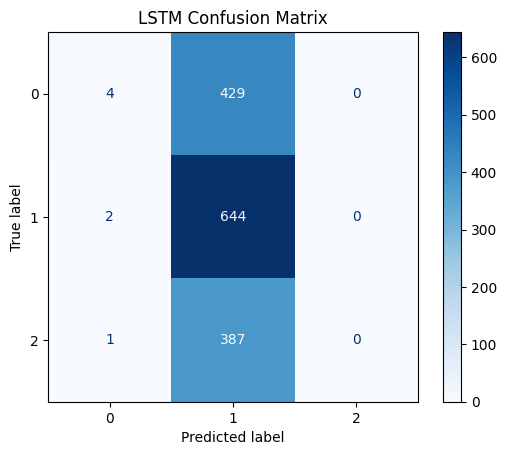

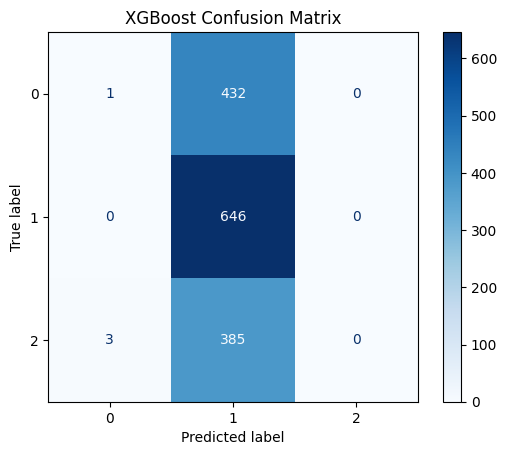

In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# LSTM confusion matrix
cm_lstm = confusion_matrix(y_te, lstm_preds)
disp_lstm = ConfusionMatrixDisplay(cm_lstm)
disp_lstm.plot(cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.show()

# XGBoost confusion matrix
cm_xgb = confusion_matrix(y_te, xgb_preds)
disp_xgb = ConfusionMatrixDisplay(cm_xgb)
disp_xgb.plot(cmap='Blues')
plt.title('XGBoost Confusion Matrix')
plt.show()


## Етап 4. Модель оцінки ризиків

1. **Оцінка волатильності**

   * GARCH(1,1) для прогнозу σ²ₜ:

     $$
       σ_t^2 = ω + α ε_{t-1}^2 + β σ_{t-1}^2
     $$
2. **Кореляційна структура портфеля**

   * Shrinkage-оцінка коваріаційної матриці (Ledoit–Wolf).
3. **VaR / CVaR**

   * Історичний VaR, параметричний (нормальний розподіл).
4. **Розрахунок погрозливості позицій**

   * Position sizing за правилом Kelly або Risk parity.

In [17]:
from arch import arch_model
from sklearn.covariance import LedoitWolf
from scipy.stats import norm
from scipy.special import erfinv
from scipy.stats import norm
import pandas as pd
import numpy as np

def fit_garch(series: pd.Series):
    """
    Підганяє GARCH(1,1) модель до доходностей series, повертає прогноз дисперсії
    """
    ret = series.dropna() * 100  # масштабування для стабільності
    am = arch_model(ret, vol='Garch', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    # прогноз волатильності на наступний період
    forecast = res.forecast(horizon=1)
    var_forecast = forecast.variance.iloc[-1, 0] / (100**2)
    return var_forecast, res.params


def shrinkage_covariance(returns: pd.DataFrame):
    """
    Оцінює коваріаційну матрицю з застосуванням Ledoit-Wolf shrinkage
    """
    lw = LedoitWolf().fit(returns.dropna()) # Ensure NaNs are handled
    return pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns)


def compute_var_cvar(returns: pd.Series, alpha: float = 0.05):
    """
    Обчислює історичний та параметричний VaR і CVaR на рівні alpha
    """
    ret = returns.dropna()
    if ret.empty:
        return {
            'VaR_historical': np.nan,
            'CVaR_historical': np.nan,
            'VaR_parametric': np.nan,
            'CVaR_parametric': np.nan
        }
    # Historical VaR
    var_hist = -np.quantile(ret, alpha)
    cvar_hist = -ret[ret <= np.quantile(ret, alpha)].mean()
    # Parametric (normal)
    mu, sigma = ret.mean(), ret.std()
    # Handle cases where sigma might be zero or NaN
    if sigma == 0 or np.isnan(sigma):
        var_param = -mu
        cvar_param = -mu
    else:
        norm_ppf_alpha = norm.ppf(alpha)
        var_param = -(mu + sigma * norm_ppf_alpha)
        cvar_param = -(mu - sigma * norm.pdf(norm_ppf_alpha) / alpha)
    return {
        'VaR_historical': var_hist,
        'CVaR_historical': cvar_hist,
        'VaR_parametric': var_param,
        'CVaR_parametric': cvar_param
    }


def kelly_allocation(returns: pd.Series):
    """
    Обчислює Келлі-оптимальні ваги для одного активу: w = mu/var
    """
    mu = returns.mean()
    var = returns.var()
    if var == 0 or np.isnan(var): # Avoid division by zero
        return np.nan
    return mu / var


def risk_parity_weights(cov_matrix: pd.DataFrame):
    """
    Простий ризик-паритет: ваги пропорційні зворотньому волатильності
    """
    vol = np.sqrt(np.diag(cov_matrix))
    # Handle zero volatility
    if np.any(vol == 0):
        # Assign zero weight to assets with zero volatility, distribute rest
        non_zero_vol_indices = np.where(vol != 0)[0]
        if len(non_zero_vol_indices) == 0:
             # If all have zero vol, return equal weights (or handle as error)
             return pd.Series(1/len(vol) if len(vol) > 0 else 0, index=cov_matrix.index)
        inv_vol = np.zeros_like(vol)
        inv_vol[non_zero_vol_indices] = 1 / vol[non_zero_vol_indices]
    else:
        inv_vol = 1 / vol
    w = inv_vol / np.sum(inv_vol)
    return pd.Series(w, index=cov_matrix.index)

# ---------- Приклад використання ----------

if isinstance(y, pd.DataFrame):
    # Якщо y - DataFrame, беремо стовпець 'Close' або перший стовпець
    if 'Close' in y.columns:
        prices = y['Close']
        price_series_name = 'Close'
    elif not y.empty:
         prices = y.iloc[:, 0]
         price_series_name = y.columns[0]
    else:
        # Якщо DataFrame порожній, створити порожню Series, щоб уникнути помилок далі
        # Або краще викликати помилку, якщо дані необхідні
        raise ValueError("DataFrame 'y' порожній.")
elif isinstance(y, pd.Series):
    prices = y
    price_series_name = y.name if y.name else 'Price'
else:
    raise TypeError("Змінна 'y' не є ні DataFrame, ні Series.")

# Розраховуємо доходності - припускаємо, що prices має достатньо даних
returns = prices.pct_change().dropna()
if returns.empty:
    raise ValueError("Не вдалося розрахувати доходності (недостатньо даних).")


# 1. GARCH
var_forecast, params = fit_garch(returns)
print('GARCH σ² forecast:', var_forecast)
print('GARCH Params:', params)

# 2. Shrinkage cov
returns_df = returns.to_frame(name=price_series_name)
if returns_df.shape[0] <= 1:
    raise ValueError("Shrinkage Covariance: Недостатньо даних (потрібно > 1).")
cov_shrunk = shrinkage_covariance(returns_df)
print('Shrinkage Covariance Matrix:\n', cov_shrunk)

# 3. VaR/CVaR
res = compute_var_cvar(returns, alpha=0.05)
print('VaR/CVaR Results:', res)

# 4. Position sizing
kelly_w = kelly_allocation(returns)
print('Kelly weight:', kelly_w)

# Risk Parity - припускаємо, що cov_shrunk розраховано успішно
rp_w = risk_parity_weights(cov_shrunk)
print('Risk parity weights:', rp_w)

GARCH σ² forecast: 0.00014614605040313711
GARCH Params: mu          0.132439
omega       0.028493
alpha[1]    0.051811
beta[1]     0.943469
Name: params, dtype: float64
Shrinkage Covariance Matrix:
           AAPL
AAPL  0.000367
VaR/CVaR Results: {'VaR_historical': np.float64(0.02563475848973029), 'CVaR_historical': np.float64(0.044302435720977036), 'VaR_parametric': np.float64(0.03068256403649917), 'CVaR_parametric': np.float64(0.0386874926425848)}
Kelly weight: 2.255910217624994
Risk parity weights: AAPL    1.0
dtype: float64


## Етап 5. Модель транзакційних витрат

1. **Параметрична модель**

   * Вартість = мікросприйняття + постійна комісія:

     $$
       C = c_0 + c_1 \times \mathrm{Volume} + c_2 \times \mathrm{Spread}
     $$
2. **Імітація спреду**

   * Використати реальні bid–ask дані або задати умовні величини.

In [58]:
import numpy as np
import pandas as pd

# =====================
# === Етап 5: Модель транзакційних витрат ===
# =====================

# --- 1. Параметрична модель вартості ---

def compute_transaction_cost(volume: pd.Series,
                             spread: pd.Series,
                             c0: float = 0.0,
                             c1: float = 0.5,
                             c2: float = 0.5) -> pd.Series:
    """
    Обчислює транзакційні витрати за моделлю:
        C = c0 + c1 * Volume + c2 * Spread
    Аргументи:
        volume -- обсяг торгів (кількість лотів або валютних одиниць)
        spread -- bid-ask spread у цих самих одиницях ціни
        c0, c1, c2 -- параметри моделі
    Повертає:
        Series з вартістю транзакцій по кожному періоду
    """
    cost = c0 + c1 * volume + c2 * spread
    return pd.Series(cost, index=volume.index, name='transaction_cost')

# --- 2. Імітація спреду ---

def simulate_spread(prices: pd.Series,
                    avg_spread_pct: float = 0.001,
                    volatility_factor: float = 0.1,
                    random_state: int = None) -> pd.Series:
    """
    Імітує bid-ask spread на основі ціни:
        spread_t = price_t * (avg_spread_pct + volatility_factor * z_t)
    де z_t ~ N(0,1)
    Аргументи:
        prices -- серія цін закриття
        avg_spread_pct -- середній спред у відсотках від ціни
        volatility_factor -- коефіцієнт, що змінює спред від випадкової флуктуації
        random_state -- seed для відтворюваності
    Повертає:
        Series зі спредом у тих же одиницях, що й ціна
    """
    rng = np.random.default_rng(seed=random_state)
    z = rng.standard_normal(len(prices))
    spread = prices * (avg_spread_pct + volatility_factor * z)
    # гарантовано позитивний спред
    spread = np.abs(spread)
    return pd.Series(spread, index=prices.index, name='spread')


volume = X['Volume']

# Імітуємо спред на основі ціни
spread = simulate_spread(prices, avg_spread_pct=0.001, volatility_factor=0.01, random_state=42)

# Обчислюємо транзакційні витрати, використовуючи обсяг з X
costs = compute_transaction_cost(volume, spread, c0=0.5, c1=0.005, c2=0.2)

# Комбінуємо у DataFrame для аналізу
result = pd.concat([prices.rename('Price'), volume.rename('Volume'), spread, costs], axis=1)
print(result.tail())

                 Price        Volume    spread  transaction_cost
Date                                                            
2024-09-15  217.900431  5.182713e+07  3.026479     259136.771962
2024-09-16  215.844955  5.935740e+07  1.830040     296787.866008
2024-09-17  216.313904  4.551930e+07  1.124825     227597.224965
2024-09-18  220.205353  5.989490e+07  0.389916     299475.077983
2024-11-04  221.522446  4.494450e+07  0.000939     224723.000188


## Етап 6. Портфельна модель

1. **Оптимізація портфеля**

   * Mean–variance оптимізація з урахуванням прогнозованої α і σ:

     $$
       \max_w w^T \mu_p - λ w^T Σ w
     $$
   * Robust optimization / Black–Litterman (за бажанням).
2. **Обмеження**

   * Ліміти на position size, sector exposure, leverage.
3. **Ребалансинг**

   * Часовий інтервал (щотижня/щомісяця) або сигнал-based.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import yfinance as yf

# =====================
# === Етап 6: Портфельна модель ===
# =====================

# 1. Основна функція портфельної оптимізації

def portfolio_optimization(expected_returns: pd.Series or pd.DataFrame,
                         cov_matrix: pd.DataFrame,
                         risk_aversion: float = 2.0,
                         constraints: dict = None) -> dict:
    """
    Оптимізує портфель за mean-variance критерієм:
        max_w w^T μ_p - λ w^T Σ w
    Аргументи:
        expected_returns -- очікувані доходності (Series або DataFrame для одного чи багатьох активів)
        cov_matrix -- коваріаційна матриця доходностей
        risk_aversion -- параметр неприйняття ризику (λ)
        constraints -- словник з обмеженнями на ваги
    Повертає:
        словник з оптимальними вагами та метриками
    """
    # Підготовка даних
    if isinstance(expected_returns, pd.Series):
        exp_rets = expected_returns.to_frame()
    else:
        exp_rets = expected_returns.copy()
    
    n_assets = len(exp_rets.columns)
    
    # Встановлення обмежень за замовчуванням, якщо не надано
    if constraints is None:
        constraints = {
            'weight_bounds': (0.0, 1.0),  # Без шорту
            'sum_weights': 1.0,           # Повна інвестиція
            'max_position': 0.4,          # Максимальна позиція на актив
            'sector_limits': None         # Ліміти за секторами
        }
    
    # Функція цілі: від'ємний скор Шарпа (максимізуємо)
    def objective(weights):
        # Очікувана доходність
        portfolio_return = np.dot(weights, exp_rets.values.flatten())
        # Ризик
        portfolio_variance = np.dot(weights.T, np.dot(cov_matrix.values, weights))
        # Мінімізуємо -1 * (дохідність - лямбда * ризик)
        return -1 * (portfolio_return - risk_aversion * portfolio_variance)
    
    # Обмеження у формі для scipy.optimize
    weight_bounds = [constraints.get('weight_bounds', (0.0, 1.0)) for _ in range(n_assets)]
    sum_weights_constraint = {'type': 'eq', 'fun': lambda w: np.sum(w) - constraints.get('sum_weights', 1.0)}
    
    # Максимальна позиція
    max_pos = constraints.get('max_position', 1.0)
    max_position_constraints = []
    if max_pos < 1.0:
        for i in range(n_assets):
            max_position_constraints.append({'type': 'ineq', 'fun': lambda w, i=i: max_pos - w[i]})
    
    # Всі разом
    all_constraints = [sum_weights_constraint] + max_position_constraints
    
    # Початкове рішення - рівні ваги
    initial_weights = np.ones(n_assets) / n_assets
    
    # Оптимізація
    result = minimize(objective, initial_weights, method='SLSQP',
                    bounds=weight_bounds, constraints=all_constraints)
    
    # Підготовка результатів
    weights = pd.Series(result['x'], index=exp_rets.columns)
    portfolio_return = np.dot(weights, exp_rets.values.flatten())
    portfolio_risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix.values, weights)))
    
    return {
        'weights': weights,
        'expected_return': portfolio_return,
        'risk': portfolio_risk,
        'sharpe': portfolio_return / portfolio_risk if portfolio_risk > 0 else 0
    }

# 2. Black-Litterman модель

def black_litterman(market_weights: pd.Series,
                  cov_matrix: pd.DataFrame,
                  risk_aversion: float,
                  views: dict,
                  view_confidences: dict,
                  tau: float = 0.025) -> pd.Series:
    """
    Реалізує Black-Litterman модель для включення поглядів інвестора
    Аргументи:
        market_weights -- ринкові ваги активів
        cov_matrix -- коваріаційна матриця
        risk_aversion -- параметр неприйняття ризику
        views -- словник з поглядами {asset: expected_return}
        view_confidences -- словник з впевненістю у поглядах {asset: confidence}
        tau -- параметр що відображає невпевненість у ринковій рівновазі
    Повертає:
        Series з оптимальними вагами
    """
    n_assets = len(market_weights)
    
    # Вивести імпліцитні очікувані доходності з ринкових ваг
    implied_returns = risk_aversion * np.dot(cov_matrix, market_weights)
    implied_returns = pd.Series(implied_returns, index=market_weights.index)
    
    # Підготувати матрицю поглядів P
    assets_with_views = list(views.keys())
    P = np.zeros((len(assets_with_views), n_assets))
    for i, asset in enumerate(assets_with_views):
        asset_idx = market_weights.index.get_loc(asset)
        P[i, asset_idx] = 1
    
    # Підготувати вектор поглядів Q
    Q = np.array([views[asset] for asset in assets_with_views])
    
    # Підготувати матрицю впевненості Omega
    view_vars = np.zeros(len(assets_with_views))
    for i, asset in enumerate(assets_with_views):
        asset_idx = market_weights.index.get_loc(asset)
        view_vars[i] = cov_matrix.iloc[asset_idx, asset_idx] / view_confidences[asset]
    Omega = np.diag(view_vars)
    
    # Формула Black-Litterman
    cov_scaled = tau * cov_matrix.values
    A = np.dot(P, np.dot(cov_scaled, P.T)) + Omega
    b = np.dot(P, implied_returns.values) - Q
    x = np.linalg.solve(A, -b)
    BL_returns = implied_returns.values + np.dot(cov_scaled, np.dot(P.T, x))
    BL_returns = pd.Series(BL_returns, index=market_weights.index)
    
    # Оптимізація з BL очікуваними доходностями
    result = portfolio_optimization(BL_returns, cov_matrix, risk_aversion)
    
    return result['weights']

# 3. Метод ребалансування

def rebalance_portfolio(current_weights: pd.Series,
                      target_weights: pd.Series,
                      threshold: float = 0.05,
                      tc_model=None) -> tuple:
    """
    Застосовує правило ребалансування з порогом
    Аргументи:
        current_weights -- поточні ваги
        target_weights -- цільові ваги
        threshold -- поріг для ребалансування (% відхилення)
        tc_model -- модель транзакційних витрат, якщо є
    Повертає:
        кортеж (нові ваги, сума транзакційних витрат)
    """
    # Розрахунок абсолютного відхилення
    deviation = np.abs(current_weights - target_weights)
    
    # Виявлення активів, які потребують ребалансування
    to_rebalance = deviation > threshold
    
    if not any(to_rebalance):
        return current_weights, 0.0
    
    # Нові ваги після ребалансування
    new_weights = current_weights.copy()
    new_weights[to_rebalance] = target_weights[to_rebalance]
    
    # Нормалізація, щоб сума була 1
    new_weights = new_weights / new_weights.sum()
    
    # Вартість транзакцій, якщо модель надана
    if tc_model:
        turnover = np.abs(new_weights - current_weights).sum() / 2
        tc = tc_model(turnover)
    else:
        # Приблизний розрахунок, якщо модель не надана
        turnover = np.abs(new_weights - current_weights).sum() / 2
        tc = turnover * 0.0025  # Спрощений розрахунок (0.25%)
    
    return new_weights, tc


# =====================
# === Демонстрація на даних ===
# =====================

# Конвертуємо одиночний актив у портфельний формат, якщо потрібно
if isinstance(y, pd.Series):
    assets_data = pd.DataFrame(y)
elif isinstance(y, pd.DataFrame):
    # Переконуємось що з нас DataFrame
    assets_data = y.copy()
else:
    raise TypeError("Змінна 'y' не є ні DataFrame, ні Series.")

# Перевірка: якщо у нас лише один актив, додамо ще декілька для демонстрації
if len(assets_data.columns) == 1:
    print("У даних лише один актив. Додаємо інші активи для демонстрації портфельних концепцій.")
    # Завантажимо додаткові дані для демонстрації
    additional_tickers = ['MSFT', 'AMZN', 'GOOGL']
    end_date = '2024-12-31' if 'END_DATE' not in globals() else globals()['END_DATE']
    start_date = '2022-01-01'  # Коротший період для демонстрації
    
    for ticker in additional_tickers:
        try:
            # Завантаження даних
            data = yf.download(ticker, start=start_date, end=end_date, progress=False)['Close']
            # Додавання до assets_data
            assets_data[ticker] = data
        except Exception as e:
            print(f"Помилка завантаження даних для {ticker}: {e}")
    
    # Скоротимо дані для спільного періоду
    assets_data = assets_data.dropna()

    if len(assets_data.columns) == 1:
        print("Не вдалося завантажити додаткові активи. Демонструємо на одному активі.")

# Розрахунок доходностей
returns = assets_data.pct_change().dropna()

# Прогнозовані майбутні доходності (використовуємо історичні середні як приклад)
forecast_returns = returns.mean()

# Коваріаційна матриця (використовуємо shrinkage_covariance)
cov_matrix = shrinkage_covariance(returns)

# Параметр неприйняття ризику
lambda_risk_aversion = 2.0

# Оптимізація портфеля
print("\n1. Класична оптимізація портфеля:")
port_result = portfolio_optimization(forecast_returns, cov_matrix, lambda_risk_aversion)
print("Оптимальні ваги:")
print(port_result['weights'])
print(f"Очікувана доходність: {port_result['expected_return']:.6f}")
print(f"Ризик: {port_result['risk']:.6f}")
print(f"Коефіцієнт Шарпа: {port_result['sharpe']:.4f}")

# Демонстрація Black-Litterman
print("\n2. Демонстрація Black-Litterman з інвестиційними поглядами:")

# Припустимо, що ринкові ваги пропорційні капіталізації
# Для простоти використовуємо рівні ваги
market_weights = pd.Series(1 / len(assets_data.columns), index=assets_data.columns)
market_weights = market_weights / market_weights.sum()

# Наші погляди (приклад: перший актив матиме вищу доходність)
first_asset = assets_data.columns[0]
views = {first_asset: forecast_returns[first_asset] * 1.5}
view_confidences = {first_asset: 0.75}  # 75% впевненість у прогнозі

# Застосування моделі Black-Litterman
bl_weights = black_litterman(market_weights, cov_matrix, lambda_risk_aversion, views, view_confidences)
print("Black-Litterman ваги з урахуванням поглядів:")
print(bl_weights)

# Демонстрація ребалансування
print("\n3. Демонстрація ребалансування:")
# Припустимо, що портфель відхилився через зміни цін
current_weights = port_result['weights'] * np.random.normal(1, 0.1, len(port_result['weights']))
current_weights = current_weights / current_weights.sum()
print("Поточні ваги:")
print(current_weights)

# Ребалансування з порогом 5%
new_weights, tc = rebalance_portfolio(current_weights, port_result['weights'], threshold=0.05)
print("Нові ваги після ребалансування:")
print(new_weights)
print(f"Оцінка транзакційних витрат: {tc:.6f}")

# Візуалізація ваг до і після ребалансування
weights_df = pd.DataFrame({'Початкові': current_weights, 'Цільові': port_result['weights'], 'Після ребалансування': new_weights})
weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Ваги портфеля до і після ребалансування')
plt.ylabel('Вага')
plt.xlabel('Актив')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Модель з одиночним активом (якщо вище не вдалося завантажити додаткові активи)
if len(assets_data.columns) == 1:
    print("\nМодель з одиночним активом:")
    asset_name = assets_data.columns[0]
    
    # Простий розрахунок оптимальної ваги для одного активу
    # Використовуємо принцип Келлі: w = mu/sigma^2 з обмеженням на макс. позицію
    mu_forecast_asset = forecast_returns[asset_name]
    sigma_sq_forecast_asset = cov_matrix.iloc[0, 0]
    optimal_weight_asset = min(mu_forecast_asset / (lambda_risk_aversion * sigma_sq_forecast_asset), 1.0)
    optimal_weight_asset = max(0, optimal_weight_asset)  # Не від'ємна вага
    
    print(f"Оптимальна вага для {asset_name}: {optimal_weight_asset:.4f}")
    print(f"Прогнозована доходність: {mu_forecast_asset:.6f}")
    print(f"Прогнозований ризик (дисперсія): {sigma_sq_forecast_asset:.6f}")


## Етап 7. Модель виконання ордерів

1. **Алгоритми роздроблення (child orders)**

   * TWAP / VWAP / POV.
2. **Вибір майданчику**

   * Симуляція виконання на різних біржах (кондишнальні latency, відмінності спреду).
3. **Формули та логіка**

   * Частина ордера $V_i = w_i V_{\text{total}}$, де $w_i$ – частка за часом/обсягом.


## Етап 8. Бек-тестинг та аналіз результативності

1. **Запуск віртуальних торгів**

   * Інтеграція всіх компонентів у єдиний pipeline.
2. **Ключові метрики**

   * CAGR, Sharpe, Max Drawdown, Calmar ratio.
3. **Візуалізації**

   * Equity-крива, розподіл доходностей, плоти волатильності.
4. **Статистика робастності**

   * Sensitivity-аналіз параметрів (пере–/недооптимізація).

## Етап 9. Інтерпретація результатів

1. **Економічна альтернатива**

   * Порівняння зі стратегією buy-and-hold.
   * Доцільність з урахуванням ризиків і транзакційних витрат.
2. **Висновки**

   * Сильні/слабкі сторони.
   * Можливі покращення (розширення моделі, інші класи активів).
